In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading a test case with some data

First we define a collision checker function.

In [2]:
def is_collision_free(x,y):
    columns = []
    columns.append(((-math.pi/2 - 0.2, -math.pi/2 + 0.2),(-0.1,0.1)))
    columns.append(((-0.2, 0.2),(-1.1,-0.9)))
    columns.append(((math.pi/2 - 0.2, math.pi/2 + 0.2),(0.9,1.1)))
    if x <= -math.pi or x > math.pi or y <= -math.pi or y > math.pi:
        raise Exception("point needs to be in [-pi,pi] x [-pi,pi]")
    for column in columns:
        in_x_col = x >= column[0][0] and x <= column[0][1]
        in_y_op = y > column[1][0] and y < column[1][1]
        if in_x_col and not in_y_op:
            return False
    return True

Now we have a look at the configuration space that this collision checker defines:

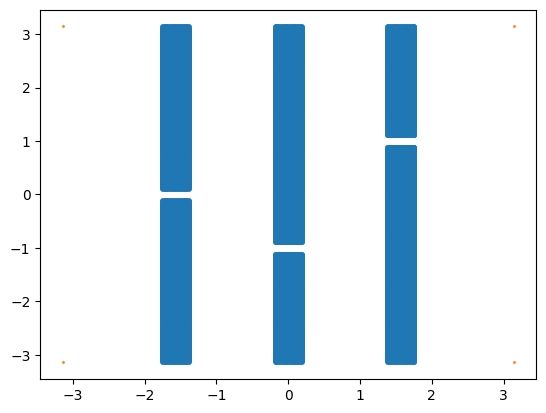

In [3]:
num_samples = 500

x_values = [ math.pi * (n/num_samples) - math.pi * (1-n/num_samples) for n in range(1,num_samples+1)]
y_values = x_values
value_grid = []
for y in y_values:
    y_section = [(x,y,is_collision_free(x,y)) for x in x_values]
    value_grid.append(y_section)

x_collisions = []
y_collisions = []
for y_row in value_grid:
    for entry in y_row:
        if not entry[2]:
            x_collisions.append(entry[0])
            y_collisions.append(entry[1])
plt.scatter(x_collisions, y_collisions, s =5)
plt.scatter([-3.1415,-3.1415, 3.1415,3.1415], [-3.1415,3.1415,-3.1415,3.1415], s = 1)

Now `value_grid` is a `500 x 500` list. It has one list for each of the 500 y-values. This list has 500 entries, one for each x-value and whether or not that point is in collision or not. Let's turn this into a `250000 x 3` tensor (250,000 data points, each with a x-value, a y-value, and a collision boolean).

In [4]:
train_data = torch.tensor([value_grid[i][j] for i in range(500) for j in range(500)])

In [5]:
train_data.shape

torch.Size([250000, 3])

In [6]:
train_data[0] # (x-coord, y-coord, collision-free (= 1))

tensor([-3.1290, -3.1290,  1.0000])

# Model 1
In this model, we are not considering the class of a point in the loss function at all, just the Euclidean distance between the original and reconstructed points.

In [7]:
class VAE1(nn.Module):
    def __init__(self, input_dim, latent_dim): # maybe adjust to take hidden layer dimension in as input?
        super(VAE1, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim * 2)  # Two times latent_dim for mean and log-variance
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encoding
        enc_output = self.encoder(x)
        mu, logvar = enc_output[:, :latent_dim], enc_output[:, latent_dim:]

        # Reparameterization trick
        z = self.reparameterize(mu, logvar)

        # Decoding
        dec_output = self.decoder(z)
        return dec_output, mu, logvar

In [8]:
# Define the loss function
def loss_function1(recon_x, x, mu, logvar, alpha = 1):
    # Reconstruction loss
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + alpha*kl_loss

### 2-d latent space

In [9]:
# Initialize the VAE
input_dim = 2
latent_dim = 2
vae = VAE1(input_dim, latent_dim)

In [10]:
# Training data for the first model doesn't take into account the class of points.
train_data1 = train_data[:, :2]

In [11]:
# Set up optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-2)

# Put model in training mode
vae.train()

# Training loop
num_epochs = 1000
losses = []
for epoch in range(num_epochs): # try implementing the minibatch gradient descent?
    # Forward pass
    recon_data, mu, logvar = vae(train_data1)

    # Compute the loss
    loss = loss_function1(recon_data, train_data1, mu, logvar, 0.1)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    # Print the loss for every few epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')

# Now you can use the trained VAE for encoding and decoding

Epoch 0/1000, Loss: 1687892.125
Epoch 10/1000, Loss: 964102.5625
Epoch 20/1000, Loss: 379175.0
Epoch 30/1000, Loss: 234944.78125
Epoch 40/1000, Loss: 197014.4375
Epoch 50/1000, Loss: 169774.125
Epoch 60/1000, Loss: 158558.890625
Epoch 70/1000, Loss: 149935.1875
Epoch 80/1000, Loss: 144811.46875
Epoch 90/1000, Loss: 140685.828125
Epoch 100/1000, Loss: 137820.28125
Epoch 110/1000, Loss: 135810.640625
Epoch 120/1000, Loss: 134226.421875
Epoch 130/1000, Loss: 133079.4375
Epoch 140/1000, Loss: 132233.5
Epoch 150/1000, Loss: 131628.9375
Epoch 160/1000, Loss: 131211.484375
Epoch 170/1000, Loss: 130779.9296875
Epoch 180/1000, Loss: 130406.453125
Epoch 190/1000, Loss: 130250.8984375
Epoch 200/1000, Loss: 130069.1015625
Epoch 210/1000, Loss: 129906.828125
Epoch 220/1000, Loss: 129796.265625
Epoch 230/1000, Loss: 129625.171875
Epoch 240/1000, Loss: 129463.2890625
Epoch 250/1000, Loss: 129392.53125
Epoch 260/1000, Loss: 129342.7109375
Epoch 270/1000, Loss: 129173.046875
Epoch 280/1000, Loss: 12921

Text(0, 0.5, 'loss')

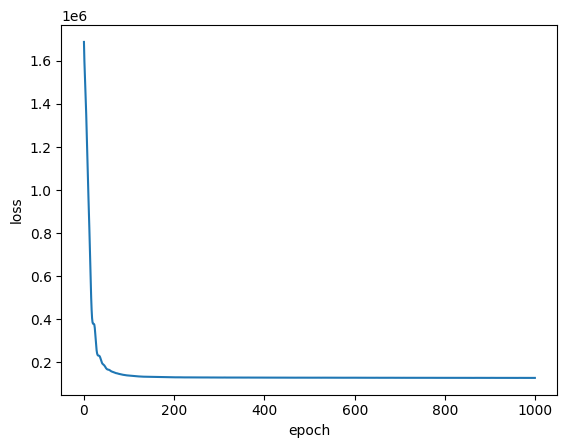

In [12]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')

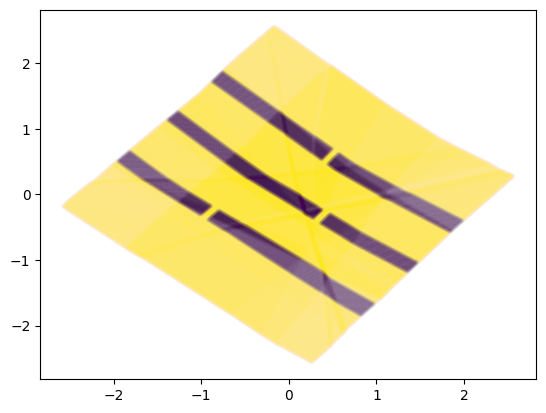

In [13]:
embeds = vae.encoder(train_data1)[:, :latent_dim]
plt.scatter(embeds[:,0].detach(), embeds[:,1].detach(), c = train_data[:,2], alpha = 0.01, s = 5)

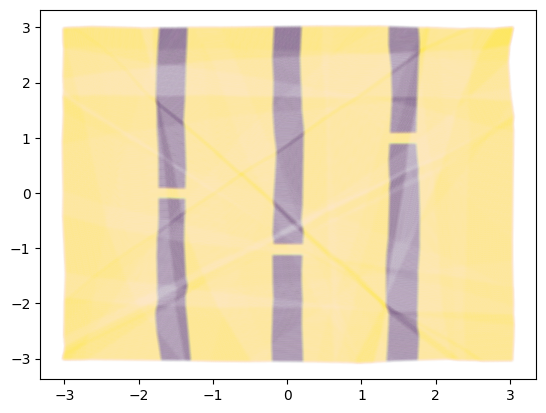

In [14]:
decodes = vae.decoder(embeds).detach()
plt.scatter(decodes[:,0], decodes[:,1], c = train_data[:,2], alpha = 0.01, s = 5)

### 1-d latent space

In [15]:
# Initialize the VAE
input_dim = 2
latent_dim = 1
vae = VAE1(input_dim, latent_dim)

In [16]:
# Training data for the first model doesn't take into account the class of points.
train_data1 = train_data[:, :2]

In [17]:
# Set up optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training loop
num_epochs = 1000
losses = []
for epoch in range(num_epochs): # try implementing the minibatch gradient descent?
    # Forward pass
    recon_data, mu, logvar = vae(train_data1)

    # Compute the loss
    loss = loss_function1(recon_data, train_data1, mu, logvar, 0.01)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    # Print the loss for every few epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')

# Now you can use the trained VAE for encoding and decoding

Epoch 0/1000, Loss: 1803719.625
Epoch 10/1000, Loss: 1689108.375
Epoch 20/1000, Loss: 1617559.0
Epoch 30/1000, Loss: 1541320.75
Epoch 40/1000, Loss: 1431047.0
Epoch 50/1000, Loss: 1286533.0
Epoch 60/1000, Loss: 1128651.625
Epoch 70/1000, Loss: 993231.0625
Epoch 80/1000, Loss: 911454.4375
Epoch 90/1000, Loss: 872511.125
Epoch 100/1000, Loss: 846982.375
Epoch 110/1000, Loss: 824793.6875
Epoch 120/1000, Loss: 805963.6875
Epoch 130/1000, Loss: 788467.0
Epoch 140/1000, Loss: 770050.125
Epoch 150/1000, Loss: 752034.1875
Epoch 160/1000, Loss: 733631.125
Epoch 170/1000, Loss: 715237.9375
Epoch 180/1000, Loss: 697210.125
Epoch 190/1000, Loss: 680104.0
Epoch 200/1000, Loss: 664107.9375
Epoch 210/1000, Loss: 649748.0625
Epoch 220/1000, Loss: 636993.4375
Epoch 230/1000, Loss: 626473.0
Epoch 240/1000, Loss: 617035.6875
Epoch 250/1000, Loss: 609250.375
Epoch 260/1000, Loss: 602430.25
Epoch 270/1000, Loss: 596393.9375
Epoch 280/1000, Loss: 591000.5625
Epoch 290/1000, Loss: 586355.5625
Epoch 300/1000,

Text(0, 0.5, 'loss')

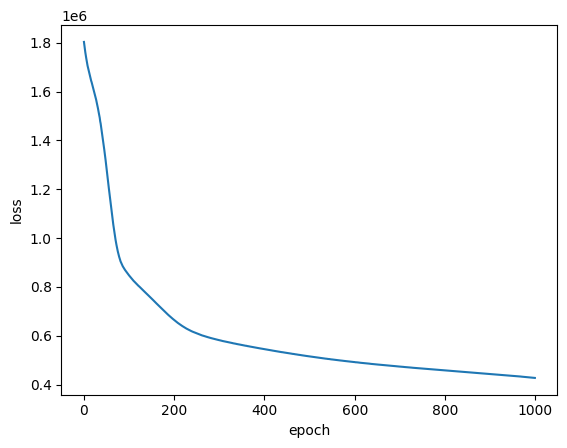

In [18]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')

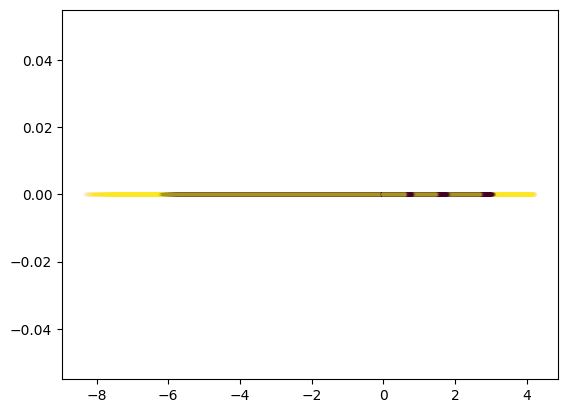

In [19]:
embeds = vae.encoder(train_data1)[:, :latent_dim]
plt.scatter(embeds[:,0].detach(), torch.zeros_like(embeds[:,0].detach()), c = train_data[:,2], alpha = 0.01, s = 5)

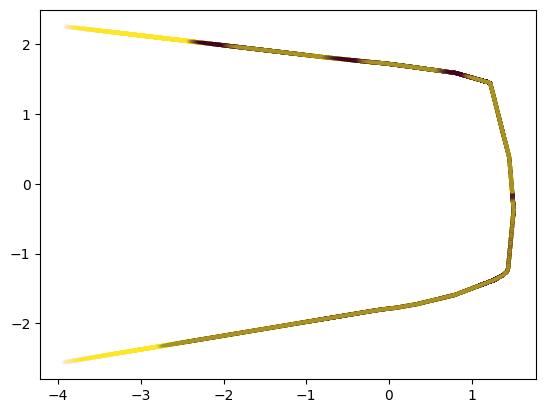

In [20]:
decodes = vae.decoder(embeds).detach()
plt.scatter(decodes[:,0], decodes[:,1], c = train_data[:,2], alpha = 0.01, s = 5)

# With minibatches

In [21]:
# Initialize the VAE
input_dim = 2
latent_dim = 2
vae = VAE1(input_dim, latent_dim)

In [22]:
# Training data for the first model doesn't take into account the class of points.
train_data1 = train_data[:, :2]

In [23]:
# Where we'll keep track of the batch losses
losses = []

In [24]:
# Set up optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-4)

# Put model in training mode
vae.train()

# Set batch size
batch_size = 1000

# Training loop
num_epochs = 50
for epoch in range(num_epochs): # try implementing the minibatch gradient descent?
    # Set up a data loader
    loader = DataLoader(dataset = train_data1, batch_size = batch_size, shuffle = True)
    
    # Loop through the batches
    for batch in loader:
        # Forward pass
        recon_data, mu, logvar = vae(batch)

        # Compute the loss
        loss = loss_function1(recon_data, batch, mu, logvar, 0.1)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        # Print the loss for every few epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')

# Now you can use the trained VAE for encoding and decoding

Epoch 0/50, Loss: 6108.53466796875
Epoch 10/50, Loss: 633.47119140625
Epoch 20/50, Loss: 550.3280029296875
Epoch 30/50, Loss: 522.8278198242188
Epoch 40/50, Loss: 509.0074768066406


Text(0, 0.5, 'loss')

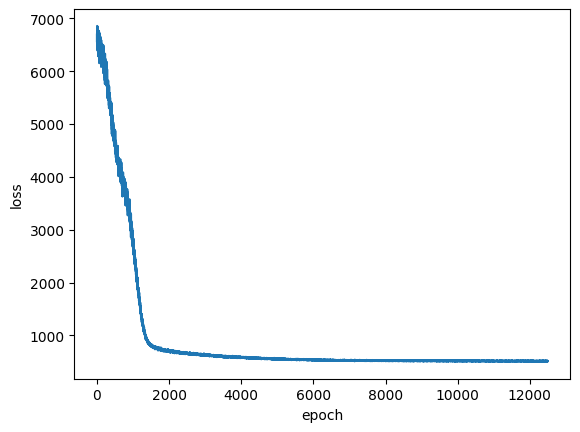

In [25]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')

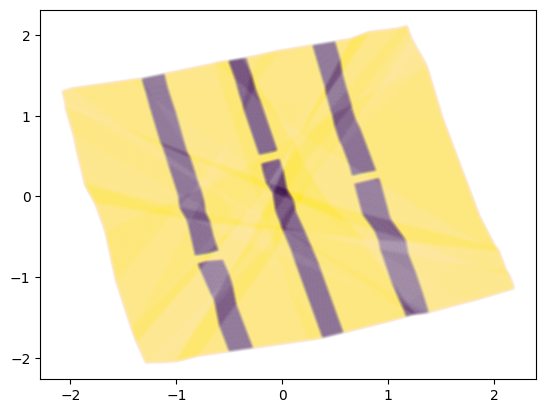

In [26]:
embeds = vae.encoder(train_data1)[:, :latent_dim]
plt.scatter(embeds[:,0].detach(), embeds[:,1].detach(), c = train_data[:,2], alpha = 0.01, s = 5)

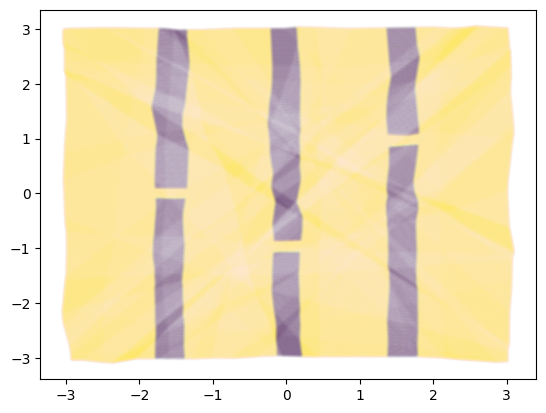

In [27]:
decodes = vae.decoder(embeds).detach()
plt.scatter(decodes[:,0], decodes[:,1], c = train_data[:,2], alpha = 0.01, s = 5)